In [1]:
import os
from contextlib import contextmanager, redirect_stderr, redirect_stdout
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

with suppress_stdout_stderr():
    import pyart


import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.io import img_tiles
import matplotlib.pyplot as plt
import sys
import os
import fsspec
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib

from utils.colormaps import *
from get_data.get_metars import get_metar_data
from get_data.get_nexrad_from_aws import get_radar

In [3]:
radar_data, radar_scan_string = get_radar()

    > RADAR SCAN FOUND: Site: KMVX Scan: 2025-10-01 | 23:09z


In [4]:
def build_map(extent=[-122, -73, 21, 56], projection=ccrs.LambertConformal()):

    fig = plt.figure(figsize=(20, 12))
    fig.set_facecolor('#009946')
    ax = plt.axes(projection=projection)
    ax.set_extent(extent)
    ax.set_box_aspect(0.7)

    ax.add_feature(cfeature.STATES, edgecolor='white', alpha=0.2, linestyle='-', linewidth=2.5, zorder=10)
    ax.add_feature(cfeature.LAND, facecolor="#1a2637", alpha=0.3, zorder=1)
    ax.add_feature(USCOUNTIES.with_scale('5m'), alpha=0.7, edgecolor='white', linestyle=':', lw=1, zorder=9)
    nd_roads = ShapelyFeature(Reader('./utils/tl_2024_38_prisecroads/tl_2024_38_prisecroads.shp').geometries(),
                               ccrs.PlateCarree(), edgecolor='navy', lw=0.8, alpha=0.4, facecolor='none', zorder=11.5)
    ax.add_feature(nd_roads)

    mn_roads = ShapelyFeature(Reader('./utils/tl_2024_27_prisecroads/tl_2024_27_prisecroads.shp').geometries(),
                               ccrs.PlateCarree(), edgecolor='navy', lw=0.8, alpha=0.4, facecolor='none', zorder=11.5)
    ax.add_feature(mn_roads)
    
    satellite = img_tiles.GoogleTiles(style='satellite')
    ax.add_image(satellite, 10) 

    # rails = ShapelyFeature(Reader('../map-elements/tl_2024_us_rails/tl_2024_us_rails.shp').geometries(),
    #                            ccrs.PlateCarree(), edgecolor='yellow', ls=':', lw=0.5, alpha=0.6, facecolor='none', zorder=11)
    # ax.add_feature(rails)

    # apply tight layout to the figure (keeps things tiddy)
    plt.tight_layout()

    # return the figure axis
    return fig, ax



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


METAR DATA RETRIEVAL COMPLETE


(np.float64(-0.5), np.float64(929.5), np.float64(424.5), np.float64(-0.5))

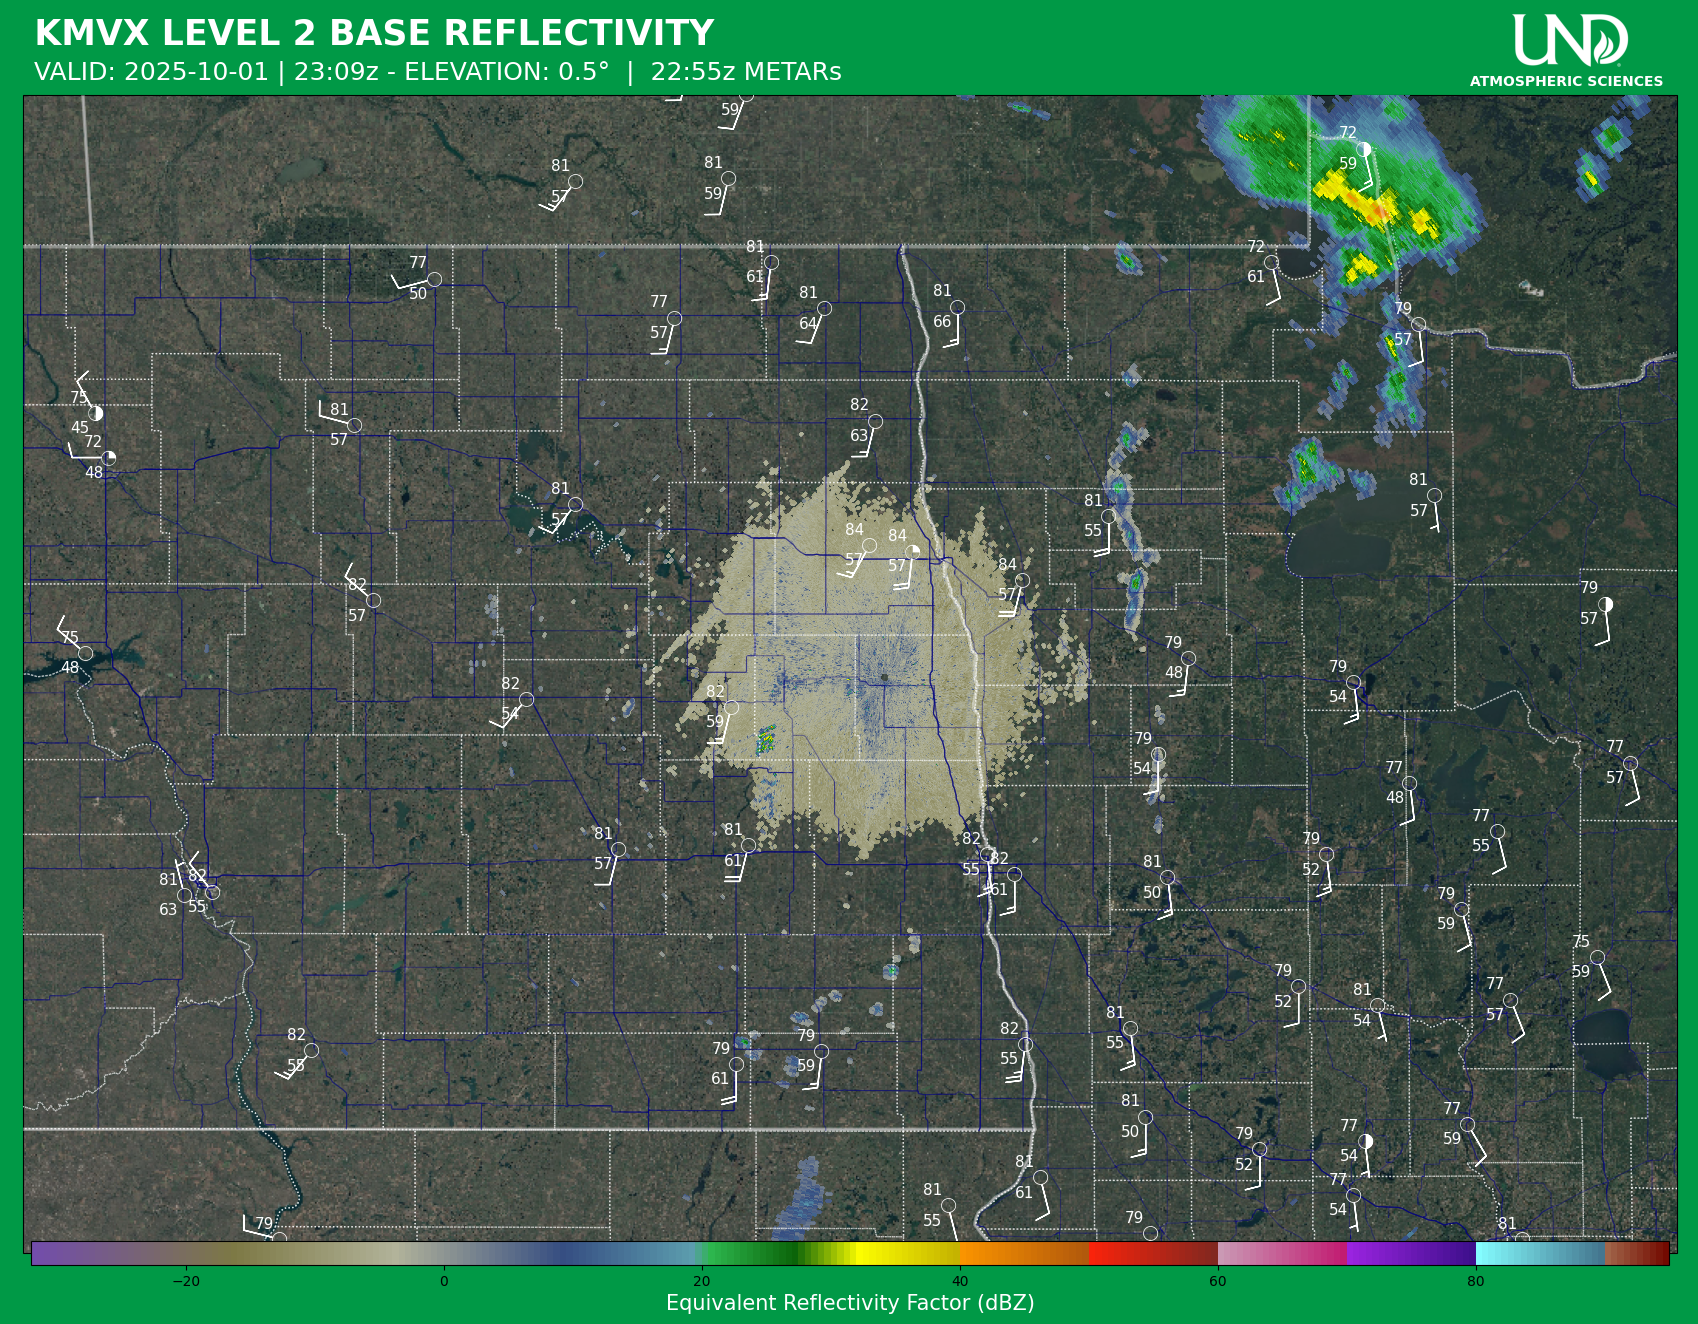

In [7]:
#################################
# BUILD MAP
#################################
center_lat = 47.5
center_lon = -97.5
box_size = 2
fig, ax = build_map(extent=[center_lon-box_size, center_lon+box_size, center_lat-box_size, center_lat+box_size],
                    projection=ccrs.Mercator())



###################################################################
# METAR STATION PLOTS
###################################################################
metar_obs, metar_time = get_metar_data(reduced_to=0)
filtered_metars = metar_obs[
    (metar_obs['latitude'] >= center_lat - box_size*2) & (metar_obs['latitude'] <= center_lat + box_size*2) &
    (metar_obs['longitude'] >= center_lon - box_size*2) & (metar_obs['longitude'] <= center_lon + box_size*2)]
filtered_metars['air_temperature'] = (filtered_metars['air_temperature']* 9/5) + 32
filtered_metars['dew_point_temperature'] = (filtered_metars['dew_point_temperature']* 9/5) + 32

from metpy.plots import StationPlot, StationPlotLayout, sky_cover
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', color='white')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', color='white')
custom_layout.add_symbol('C', 'cloud_coverage', sky_cover)
stationplot = StationPlot(ax, filtered_metars['longitude'], filtered_metars['latitude'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=11, zorder=12, alpha=1, color='white')
#stationplot.plot_text((1, -3), filtered_metars['stid'], color='white')
custom_layout.plot(stationplot, filtered_metars)


#################################
# PLOT RADAR DATA
#################################  
gatefilter = pyart.filters.GateFilter(radar_data)
gatefilter.exclude_below('reflectivity', 10)
gatefilter.exclude_equal('reflectivity', 2)
gatefilter.exclude_equal('reflectivity', 1)
display = pyart.graph.RadarMapDisplay(radar_data)
rad_display = display.plot_ppi_map(field= 'reflectivity',
                 sweep=0,
                 ax=ax,
                 vmin=-32,
                 vmax=95,
                 title_flag = False,
                 colorbar_flag = False,
                 cmap=rs_expertreflect_cmap,
                 resolution='10m',
                 lat_lines=None, 
                 lon_lines=None,
                 add_grid_lines=False,
                 #gatefilter=gatefilter
                 zorder=5,
                 alpha=0.9)
    
    
#################################
# ADD MAP EXTRAS
#################################
# plot title, add one to the left with model name and data names, add another to the right with time info
plt.figtext(0.08, 1.03, f'  KMVX LEVEL 2 BASE REFLECTIVITY', weight='bold', ha='left', fontsize=25, color='white')
plt.figtext(0.08, 1.00, f'   VALID: {radar_scan_string}z - ELEVATION: 0.5°  |  {metar_time[11:16]}z METARs', ha='left', fontsize=18, color='white')
plt.figtext(0.915, 1.04, f' ', ha='left', fontsize=20)
# colorbar for filled contour

# Define the colormap and norm
norm = colors.Normalize(vmin=-32, vmax=95)
sm = cm.ScalarMappable(cmap=rs_expertreflect_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax,  aspect=70, fraction=0.02, orientation='horizontal', pad=-0.01, extendrect=True)
cbar.set_label("Equivalent Reflectivity Factor (dBZ)", fontsize=15, color='white') 

# add UND logo
from PIL import Image
img = Image.open('utils/images/und-logo.png')
#                  side-side  up-down  size   size
imgax = fig.add_axes([0.83, 1.01, 0.06, 0.06], anchor='SE', zorder=3)
plt.figtext(0.81, 0.995, f'ATMOSPHERIC SCIENCES', ha='left', weight='bold', fontsize=10, color='white')
imgax.imshow(img)
imgax.axis('off')

plt.savefig("left_1_1.png", bbox_inches="tight")